In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

## Data preparation

In [39]:
df = pd.read_csv('course_lead_scoring.txt', sep = ',')
df

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1
...,...,...,...,...,...,...,...,...,...
1457,referral,manufacturing,1,NaN,self_employed,north_america,4,0.53,1
1458,referral,technology,3,65259.0,student,europe,2,0.24,1
1459,paid_ads,technology,1,45688.0,student,north_america,3,0.02,1
1460,referral,NaN,5,71016.0,self_employed,north_america,0,0.25,1


In [40]:
df.dtypes, df.describe()

(lead_source                  object
 industry                     object
 number_of_courses_viewed      int64
 annual_income               float64
 employment_status            object
 location                     object
 interaction_count             int64
 lead_score                  float64
 converted                     int64
 dtype: object,
        number_of_courses_viewed  annual_income  interaction_count  \
 count               1462.000000    1281.000000        1462.000000   
 mean                   2.031464   59886.273224           2.976744   
 std                    1.449717   15070.140389           1.681564   
 min                    0.000000   13929.000000           0.000000   
 25%                    1.000000   49698.000000           2.000000   
 50%                    2.000000   60148.000000           3.000000   
 75%                    3.000000   69639.000000           4.000000   
 max                    9.000000  109899.000000          11.000000   
 
         lead_score

In [41]:
df.isnull().sum(), df.nunique()

(lead_source                 128
 industry                    134
 number_of_courses_viewed      0
 annual_income               181
 employment_status           100
 location                     63
 interaction_count             0
 lead_score                    0
 converted                     0
 dtype: int64,
 lead_source                    5
 industry                       7
 number_of_courses_viewed      10
 annual_income               1267
 employment_status              4
 location                       7
 interaction_count             12
 lead_score                   101
 converted                      2
 dtype: int64)

In [42]:
categorical = ['industry','lead_source','employment_status', 'location']
numerical = ['number_of_courses_viewed','annual_income','interaction_count','lead_score']

In [43]:
df[categorical] = df[categorical].fillna('NA')
df[numerical] = df[numerical].fillna(0.0)
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [44]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

## Question 1: ROC AUC feature importance

In [45]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [50]:
scores = []
for n in numerical:
    train_num = df_train[[n]]
    val_num = df_val[[n]]

    model = LogisticRegression(solver='liblinear')
    model.fit(train_num, y_train)

    y_pred = model.predict_proba(val_num)[:,1]

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
    
    print(f'n={n} AUC={auc:.3f}')

n=number_of_courses_viewed AUC=0.742
n=annual_income AUC=0.554
n=interaction_count AUC=0.697
n=lead_score AUC=0.623


## Question 2: Training the model

In [52]:
def train(df_train, y_train, C=1.0):
    train_dict = df_train[categorical+numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dict)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

In [53]:
def predict(df, dv, model):
    dicts = df[categorical+numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]
    
    return y_pred

In [54]:
dv, model = train(df_train, y_train)

In [55]:
y_pred = predict(df_val, dv, model)

In [57]:
auc = roc_auc_score(y_val, y_pred)
auc

0.8171316268814112

## Question 3: Precision and Recall

In [62]:
thresholds = np.linspace(0.0, 1.0, 101)
thresholds

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [63]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [78]:
precision = []
recall = []
f1_scores = []

for t in thresholds:
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    p = tp / (tp + fp) if (tp + fp) > 0 else 0
    r = tp / (tp + fn) if (tp + fn) > 0 else 0

    precision.append(p)
    recall.append(r)

    f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0
    f1_scores.append(f1)

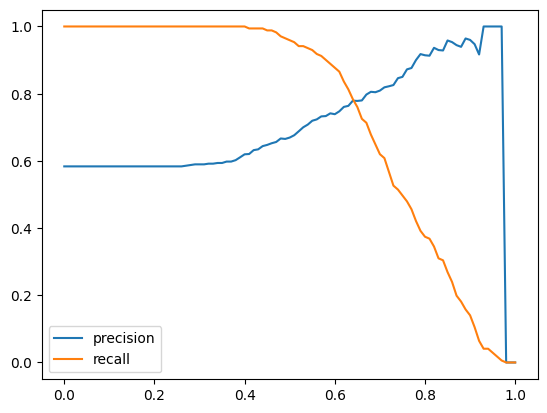

In [75]:
plt.plot(thresholds, precision, label ='precision')
plt.plot(thresholds, recall, label ='recall')
plt.legend()
plt.show()

## Question 4: F1 score

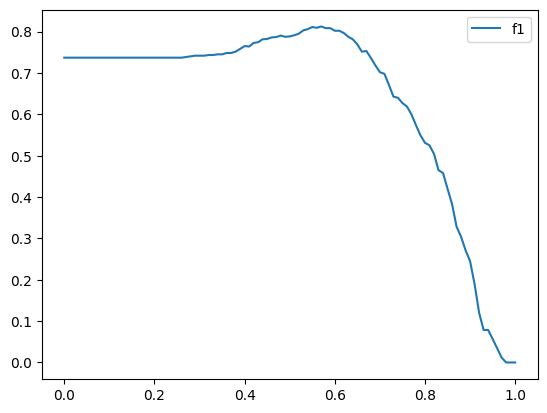

In [79]:
plt.plot(thresholds, f1_scores, label ='f1')
plt.legend()
plt.show()

In [83]:
best_idx = np.argmax(f1_scores)              
best_threshold = thresholds[best_idx]        
best_f1 = f1_scores[best_idx]                

print(f"Best threshold: {best_threshold:.2f}")
print(f"Best F1 score: {best_f1:.3f}")

Best threshold: 0.57
Best F1 score: 0.812


## Question 5: 5-Fold CV

In [86]:
from sklearn.model_selection import KFold

In [87]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print(f"auc standard deviation: {np.std(scores):.3f}")

auc standard deviation: 0.036


## Question 6: Hyperparameter Tuning

In [91]:
C = [0.000001, 0.001, 1]

for c in C:
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv, model = train(df_train, y_train, C=c)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (c, np.mean(scores), np.std(scores)))

C=1e-06 0.691 +- 0.134
C=0.001 0.750 +- 0.139
C=1 0.768 +- 0.125
